# PROYEK ANALISIS DATA: Air Quality

**Nama:** Muhammad Faisal Aktsa  
**Email:** fslfaisal17@gmail.com  
**ID Dicoding:** fslmc17  

# MENENTUKAN PERTANYAAN BISNIS
- Pada bulan dan musim apa tingkat PM2.5 dan PM10 paling tinggi, dan bagaimana faktor cuaca (suhu, tekanan udara, kelembapan, curah hujan, kecepatan angin) berkontribusi terhadap peningkatan PM2.5 dan PM10?
- Stasiun mana yang konsisten melebihi standar O3 harian (WHO: 100μg/m³) selama 3 tahun terakhir?

# IMPORT SEMUA LIBRARY

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

# DATA WRANGLING

In [ ]:
# GATHERING DATA
df_aotizhongxin = pd.read_csv("dataset/PRSA_Data_Aotizhongxin_20130301-20170228.csv", delimiter=",")
df_changpin = pd.read_csv("dataset/PRSA_Data_Changping_20130301-20170228.csv", delimiter=",")
df_dingling = pd.read_csv("dataset/PRSA_Data_Dingling_20130301-20170228.csv", delimiter=",")
df_dongsi = pd.read_csv("dataset/PRSA_Data_Dongsi_20130301-20170228.csv", delimiter=",")
df_guanyuan = pd.read_csv("dataset/PRSA_Data_Guanyuan_20130301-20170228.csv", delimiter=",")
df_gucheng = pd.read_csv("dataset/PRSA_Data_Gucheng_20130301-20170228.csv", delimiter=",")
df_huairou = pd.read_csv("dataset/PRSA_Data_Huairou_20130301-20170228.csv", delimiter=",")
df_nongzhanguan = pd.read_csv("dataset/PRSA_Data_Nongzhanguan_20130301-20170228.csv", delimiter=",")
df_shunyi = pd.read_csv("dataset/PRSA_Data_Shunyi_20130301-20170228.csv", delimiter=",")
df_tiantan = pd.read_csv("dataset/PRSA_Data_Tiantan_20130301-20170228.csv", delimiter=",")
df_wanliu = pd.read_csv("dataset/PRSA_Data_Wanliu_20130301-20170228.csv", delimiter=",")
df_wanshouxigong = pd.read_csv("dataset/PRSA_Data_Wanshouxigong_20130301-20170228.csv", delimiter=",")

dataframes = [
    df_aotizhongxin, df_changpin, df_dingling, df_dongsi, df_guanyuan,
    df_gucheng, df_huairou, df_nongzhanguan, df_shunyi, df_tiantan,
    df_wanliu, df_wanshouxigong
]

all_df = pd.concat(dataframes, ignore_index=True) # Menggabungkan semua dataframe menjadi satu variabel
all_df.head()

In [ ]:
# ASSESSING DATA
all_df.info() # Hasilnya, ada data yang null. dan format dari kolom year, month, day, hour, bisa diubah ke datetime

In [ ]:
all_df.isna().sum()

In [ ]:
print("Jumlah Duplikasi: ", all_df.duplicated().sum()) # Hasilnya, tidak ada data yang terduplikasi
all_df.describe() 
# Hasilnya, ada kemungkinan outlier pada pm2.5, pm10, SO2, NO2, CO, O3, kemungkinan kesalahan sensor. Mungkin TEMP Juga

In [ ]:
# CLEANING DATA

# 1. Mengubah format ke datetime
all_df['datetime'] = pd.to_datetime(all_df[['year', 'month', 'day', 'hour']])
all_df = all_df.drop(columns=['year', 'month', 'day', 'hour'])
all_df.info()

In [ ]:
# 2. Menangani Innacurate Value
    # Drop innacurate values berdasarkan stasiun

columns_to_drop = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
def hapus_outlier(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    maximum = Q3 + (1.5*IQR)
    minimum = Q1 - (1.5*IQR)

    kondisi_lower_than = df[column] < minimum
    kondisi_more_than = df[column] > maximum

    df.drop(df[kondisi_lower_than].index, inplace=True)
    df.drop(df[kondisi_more_than].index, inplace=True)

    return df

for index in columns_to_drop:
    all_df = all_df.groupby('station').apply(hapus_outlier, column=index).reset_index(drop=True)

In [ ]:
    # Imuputation semua Missing Values, berdasarkan masing masing stasiun. Kecuali wd, wd diberi 'unknown'
columns_to_drop.extend(['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'])
columns_to_impute = columns_to_drop

all_df['wd'].fillna('Unknown', inplace=True)

for index in columns_to_impute:
        all_df[index] = all_df.groupby('station')[index].transform(lambda x: x.fillna(x.median()))

In [ ]:
all_df.to_csv('cleaned_data.csv', index=False)

# Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv("cleaned_data.csv", delimiter=",")

In [ ]:
df.describe(include="all")

In [ ]:
df.groupby(by="station").agg({
    "PM2.5" : ["mean", "max", "median"],
    "PM10" : ["mean", "max", "median"],
    "O3" : ["mean", "max", "median"],
})

## QUESTION 1

Membuat Kolom Bulan dan Musim dan menganalisis PM2.5 & PM10 per musim <br>
Hasilnya rata rata tertinggi PM2.5 berada di musim 3 (Summer), dan paling rendah di 1 (Winter) <br>
Sedangkan untuk PM10, rata rata tertinggi berada di bulan 2 (Spring), dan terendah di 1 (winter) <br>
PM10 Memuncak tepat pada bulan April <br>
PM2.5 memuncak pada bulan juli

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['month'] = df['datetime'].dt.month
df['season'] = df['datetime'].dt.month % 12 // 3 + 1 #

pm_musim = df.groupby("season").agg({
    "PM2.5" : "mean",
    "PM10" : "mean"
}).reset_index()

monthly_pm = df.groupby('month').agg({
    'PM2.5': 'mean',
    'PM10': 'mean'
}).reset_index()

print(monthly_pm)

print(pm_musim)

    month      PM2.5        PM10
0       1  36.137976   52.134073
1       2  38.546556   52.076492
2       3  51.118599   85.559811
3       4  63.021571  101.148411
4       5  51.936554   89.760320
5       6  58.702137   75.835542
6       7  65.763660   78.305911
7       8  50.176677   66.947271
8       9  55.786425   73.665992
9      10  61.856979   82.594596
10     11  51.135313   70.252803
11     12  33.582671   50.921538
   season      PM2.5       PM10
0       1  36.155749  51.720271
1       2  55.726971  92.707035
2       3  58.085328  73.540015
3       4  56.594447  75.808598


Melihat Korelasi faktor cuaca dengan PM10 & PM2.5 <br>
Hasilnya yang memiliki korelasi terkuat, adalah DEWP (Kelembapan), dan itu termasuk kecil

In [ ]:
df[['PM2.5', 'PM10', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()

Tren bulanan PM2.5 PM10 <br>
Hasilnya, PM10 Memuncak tepat pada bulan April <br>
PM2.5 memuncak pada bulan juli

## QUESTION 2

Menandai data O3 yang diatas batas 3 tahun terakhir

In [27]:
last_three_years = df['datetime'].dt.year.max() - 2

df_filtered = df[df['datetime'].dt.year >= last_three_years]

df_filtered['O3_over'] = df_filtered['O3'] > 100

df['O3_over'] = df['O3'] > 100

station_o3_exceed = df_filtered.groupby('station')['O3_over'].sum().reset_index()
station_o3_exceed.columns = ['station', 'exceed_days']
print(station_o3_exceed)

          station  exceed_days
0    Aotizhongxin         2721
1       Changping         1745
2        Dingling         2207
3          Dongsi         2220
4        Guanyuan         2400
5         Gucheng         2501
6         Huairou         1704
7    Nongzhanguan         2521
8          Shunyi         1643
9         Tiantan         2296
10         Wanliu         2043
11  Wanshouxigong         2441


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16096\5391117.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['O3_over'] = df_filtered['O3'] > 100


Mengurutkan Pelanggaran.
hasilnya, stasiun Nongzhanguan memiliki pelanggaran terbanyak

In [31]:
station_o3_exceed.sort_values(by='exceed_days', ascending=False)

,station,exceed_days
0,Aotizhongxin,2721
7,Nongzhanguan,2521
5,Gucheng,2501
11,Wanshouxigong,2441
4,Guanyuan,2400
9,Tiantan,2296
3,Dongsi,2220
2,Dingling,2207
10,Wanliu,2043
1,Changping,1745


Melihat Tren pelanggaran tingkat O3 3 tahun terakhir
Hasilnya, kebnayakan O3 melebihi batas pada musim Summer

In [32]:
df_filtered['year'] = df_filtered['datetime'].dt.year
print(df_filtered[df_filtered['O3_over']].groupby(['season', 'year', 'month']).size().reset_index(name='exceed_days'))

    season  year  month  exceed_days
0        1  2015      2           19
1        1  2016      2           29
2        1  2017      1           80
3        1  2017      2          210
4        2  2015      3          552
5        2  2015      4         1953
6        2  2015      5         2367
7        2  2016      3          388
8        2  2016      4         1470
9        2  2016      5         2519
10       3  2015      6         2135
11       3  2015      7         2409
12       3  2015      8         2522
13       3  2016      6         2486
14       3  2016      7         2069
15       3  2016      8         2166
16       4  2015      9         1312
17       4  2015     10          299
18       4  2015     11           21
19       4  2016      9         1176
20       4  2016     10          260


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16096\494950082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['datetime'].dt.year


## Insight
**PM2.5 dan PM10, yaitu parameter untuk Partikel Halus berukuran 2.5mm dan 10mm yang terdapat di udara**
- Baik PM10 maupun PM2.5, tidak ada faktor cuaca yang secara langsung mempengaruhi kenaikan kedua polutan tersebut
- Rata-rata PM10 memuncak pada musim Semi, dan PM2.5 memuncak pada musim Panas
- Rata-rata PM10 memuncak pada bulan , dan PM2.5 pada bulan Juli
--------
**O3, yaitu parameter Ground Level Ozone, polutan yang berasal dari mobil, fasilitas pembangkit listrik, boiler industri, fasilitas kimia**
- stasiun nongzhuan memiliki jumlah pelanggaran kadar O3 paling banyak
- Pelanggaran O3 seringkali terjadi pada musim panas

# Visualization & Explanatory Analysis

In [3]:
df = pd.read_csv("cleaned_data.csv", delimiter=",")
df['datetime'] = pd.to_datetime(df['datetime'])

## QUESTION 1

<function matplotlib.pyplot.show(close=None, block=None)>

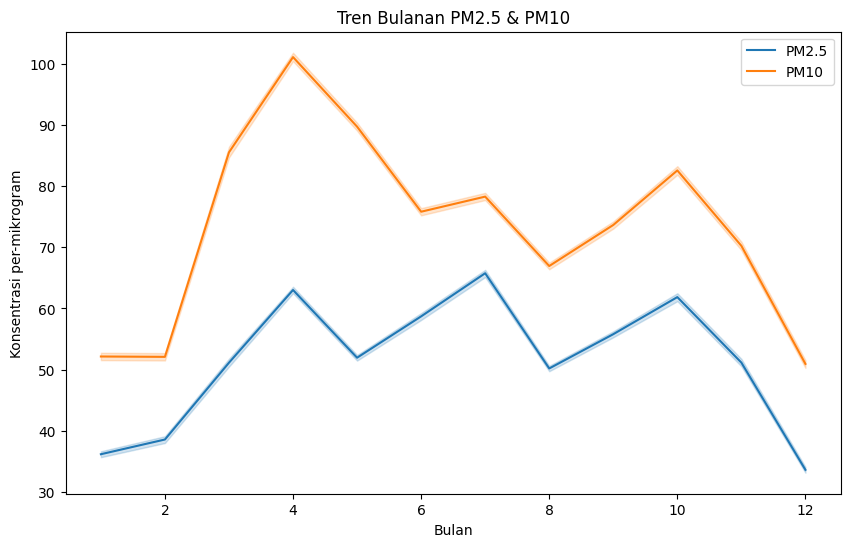

In [8]:
# QUESTION 1
df['month'] = df['datetime'].dt.month
df['season'] = df['datetime'].dt.month % 12 // 3 + 1

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month', y='PM2.5', label='PM2.5')
sns.lineplot(data=df, x='month', y='PM10', label='PM10')
plt.title('Tren Bulanan PM2.5 & PM10')
plt.xlabel('Bulan')
plt.ylabel('Konsentrasi per-mikrogram')
plt.legend()
plt.show

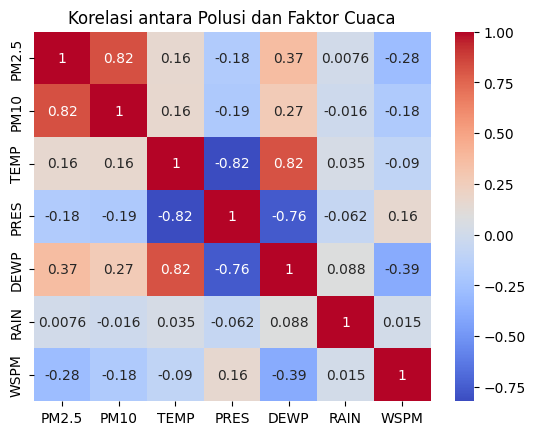

In [9]:
correlation = df[['PM2.5', 'PM10', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Korelasi antara Polusi dan Faktor Cuaca')
plt.show()

### Insight
- bla
- bla

## QUESTION 2

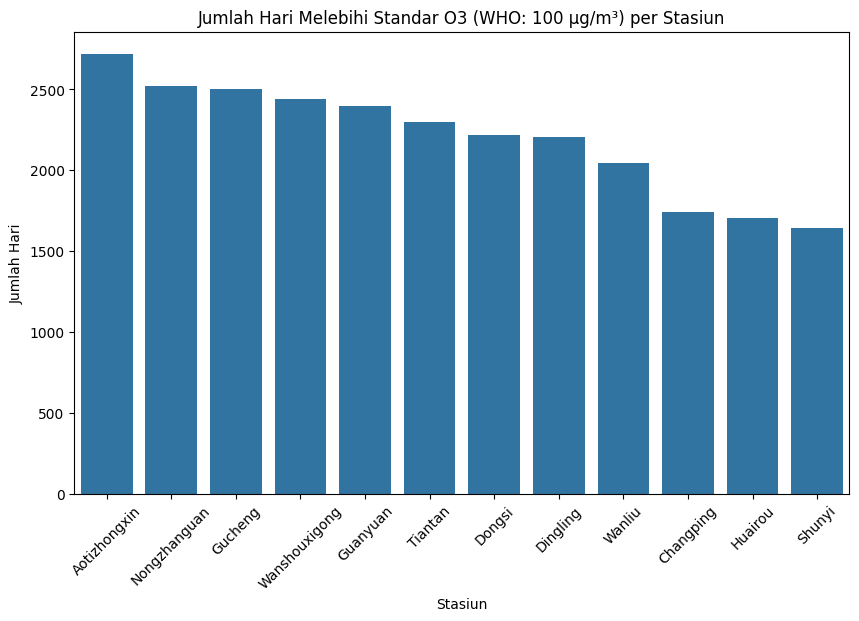

In [34]:
df_filtered = df[df['datetime'].dt.year >= last_three_years]
df_filtered = df[df['datetime'].dt.year >= last_three_years]
df['O3_over'] = df['O3'] > 100
station_o3_exceed = df_filtered.groupby('station')['O3_over'].sum().reset_index()
station_o3_exceed.columns = ['station', 'exceed_days']
o3_sorted = station_o3_exceed.sort_values(by='exceed_days', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=o3_sorted, x='station', y='exceed_days')
plt.title('Jumlah Hari Melebihi Standar O3 (WHO: 100 µg/m³) per Stasiun')
plt.xlabel('Stasiun')
plt.ylabel('Jumlah Hari')
plt.xticks(rotation=45)
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16096\1246162553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['datetime'].dt.year
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16096\1246162553.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  o3_exceed_trend = df_filtered[df['O3_over']].groupby(['year', 'month']).size().reset_index(name='exceed_days')


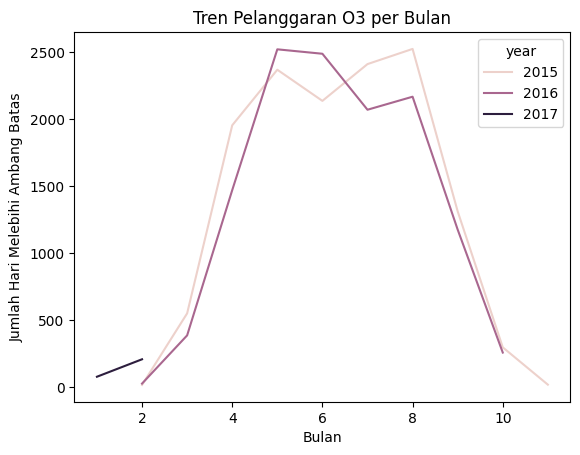

In [33]:
station_o3_exceed = df.groupby('station')['O3_over'].sum().reset_index()
station_o3_exceed.columns = ['station', 'exceed_days']


df_filtered['year'] = df_filtered['datetime'].dt.year
o3_exceed_trend = df_filtered[df['O3_over']].groupby(['year', 'month']).size().reset_index(name='exceed_days')
sns.lineplot(data=o3_exceed_trend, x='month', y='exceed_days', hue='year')
plt.title('Tren Pelanggaran O3 per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Hari Melebihi Ambang Batas')
plt.show()

### Insight
- Kebanyakan faktor cuaca tidak ada yang berhubungan langsung dengan tingkat PM10 & PM2.5
- PM10 naik mulai akhir bulan Februari dan memuncak pada bulan April
- PM2.5 naik drastis mulai akhir bulan Februari, lalu sempat turun sebelum memuncak lagi pada bulan Juli
- Seluruh Stasiun memliki jumlah pelanggaran tingkat O3 lebih dari 3000 selama 3 tahun terakhir dari data
- Level tertinggi O3 ada di tahunn 2016
- Data O3 berakhir pada bulan Februari

# CONCLUSION

## PERTANYAAN PERTAMA
PM10 & PM2.5 berada di level paling tinggi pada masa yang berbeda, yaitu PM10 pada musim Spring dan PM2.5 pada musim Summer, Lebih spesifiknya yaitu bulan April dan Juli <br>
Faktor cuaca tidak berkontribusi secara langsung terhadap berkembangnya polutan PM10 dan PM2.5

## PERTANYAAN KEDUA
Pada 3 tahun terakhir, stasiun Aotizhongxin adalah stasiun dengan jumlah pelanggaran batas O3 paling banyak, dengan jumlah lebih dari 2700 hari <br>
Namun, stasiun lain pun memiliki jumlah yang tidak kalah besar, semuanya lebih dari 1500